# 1. Introdução

## 1.1 Contexto do Problema

Este projeto tem como objetivo desenvolver um modelo de visão computacional capaz de classificar imagens de radiografia de tórax (Chest X-Ray) em duas categorias:

- **NORMAL**
- **PNEUMONIA**

A pneumonia é uma infecção que afeta os pulmões e pode ser identificada em exames de raio-x por meio de padrões radiográficos como opacidades e consolidações pulmonares.

O dataset utilizado contém 5.856 imagens validadas de pacientes pediátricos (1 a 5 anos), organizadas em conjuntos de treino e teste independentes.

Trata-se de um problema de **classificação binária supervisionada**, onde o modelo deverá aprender padrões visuais capazes de distinguir pulmões saudáveis de pulmões com sinais de infecção.

## 1.2 Métrica Oficial

A métrica principal utilizada para avaliação do modelo será a **ROC-AUC (Receiver Operating Characteristic - Area Under Curve)**.

### Justificativa para uso da ROC-AUC:

- Avalia a capacidade do modelo de separar corretamente as duas classes.
- Independe da escolha de um threshold fixo de decisão.
- É mais robusta em cenários com possível desbalanceamento entre classes.
- Muito utilizada em problemas médicos, onde avaliar sensibilidade e especificidade é fundamental.

Como o objetivo é maximizar a capacidade discriminativa do modelo, a ROC-AUC é a métrica mais adequada para este problema.


## Estrutura do Dataset

O dataset está organizado na seguinte estrutura de diretórios:


- O diretório **train/** contém as imagens utilizadas para treinamento.
- O diretório **test/** contém imagens de pacientes independentes para avaliação final.
- Cada subpasta **NORMAL** e **PNEUMONIA** dentro de **train/** e  **test/** representa uma classe.

Embora o dataset já possua divisão entre treino e teste, será necessário criar um **conjunto de validação (train/val)** a partir do conjunto de treino para seleção e ajuste do modelo.


# 2. Importação das Bibliotecas

Nesta seção foram importadas todas as bibliotecas que serão utilizadas ao longo da análise exploratória.


In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import cv2

from collections import Counter

from tqdm import tqdm

# Configurações visuais
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)


# 3. Carregamento dos Dados

Nesta etapa foi realizado o acesso ao dataset armazenado no Google Drive e foram definidos os caminhos principais que serão utilizados ao longo do notebook.


In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Definição do caminho base
BASE_PATH = Path("/content/drive/MyDrive/Desafio_Ligia/Data/chest_xray")

TRAIN_PATH = BASE_PATH / "train"
TEST_PATH = BASE_PATH / "test"

print("Train Path:", TRAIN_PATH)
print("Test Path:", TEST_PATH)


Train Path: /content/drive/MyDrive/Desafio_Ligia/Data/chest_xray/train
Test Path: /content/drive/MyDrive/Desafio_Ligia/Data/chest_xray/test


# 4. Análise Estrutural do Dataset

Nesta seção foi verificado:

- Organização das pastas.
- Classes presentes.
- Distribuição das imagens por classe.
- Possível desbalanceamento.


## 4.1 Listagem de Diretórios

Foi confirmado que as classes estão organizadas corretamente e que não existem pastas inesperadas.


In [ ]:
print("Subpastas em TRAIN:")
train_dirs = os.listdir(TRAIN_PATH)
print(train_dirs)

print("\nSubpastas em TEST:")
test_dirs = os.listdir(TEST_PATH)
print(test_dirs)


Subpastas em TRAIN:
['NORMAL', 'PNEUMONIA']

Subpastas em TEST:
['NORMAL', 'PNEUMONIA']


### Conclusão

As classes identificadas são:

- NORMAL
- PNEUMONIA

A organização do dataset está correta e não há diretórios inesperados.


## 4.2 Criação dos DataFrames

Foram criados dois DataFrames:

- train_df
- test_df

Cada um contendo:
- image_path
- class
- filename
- patient_id


In [ ]:
def build_dataframe(base_path):
    data = []

    for class_name in os.listdir(base_path):
        class_path = base_path / class_name

        if not class_path.is_dir():
            continue

        for img_name in os.listdir(class_path):
            img_path = class_path / img_name

            parts = img_name.split("-")
            patient_id = parts[1] if len(parts) > 1 else "unknown"

            data.append({
                "image_path": str(img_path),
                "class": class_name,
                "filename": img_name,
                "patient_id": patient_id
            })

    return pd.DataFrame(data)

train_df = build_dataframe(TRAIN_PATH)
test_df = build_dataframe(TEST_PATH)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (5232, 4)
Test shape: (624, 4)


In [ ]:
train_df.head()


,image_path,class,filename,patient_id
0,/content/drive/MyDrive/Desafio_Ligia/Data/ches...,NORMAL,NORMAL-3482198-0003.jpeg,3482198
1,/content/drive/MyDrive/Desafio_Ligia/Data/ches...,NORMAL,NORMAL-3514363-0001.jpeg,3514363
2,/content/drive/MyDrive/Desafio_Ligia/Data/ches...,NORMAL,NORMAL-3484856-0001.jpeg,3484856
3,/content/drive/MyDrive/Desafio_Ligia/Data/ches...,NORMAL,NORMAL-3514363-0004.jpeg,3514363
4,/content/drive/MyDrive/Desafio_Ligia/Data/ches...,NORMAL,NORMAL-3514363-0002.jpeg,3514363


## 4.3 Checagem de integridade (train_df e test_df)

Esta seção verifica:
- valores ausentes por coluna
- caminhos de imagem inválidos (arquivo não encontrado)
- duplicatas por metadados (image_path, filename)
- duplicatas por conteúdo (hash dos pixels)

As tabelas abaixo registram a presença e a frequência de cada problema, além de exemplos quando aplicável.


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import hashlib

def _exists(p):
    try:
        return Path(p).exists()
    except Exception:
        return False

def compute_image_hash(path):
    img = Image.open(path).convert("L")
    arr = np.asarray(img)
    img.close()
    return hashlib.md5(arr.tobytes()).hexdigest()


In [ ]:
def integrity_summary(df, name):
    cols = set(df.columns)

    missing_per_col = df.isna().sum()
    missing_total = int(missing_per_col.sum())
    missing_cols = int((missing_per_col > 0).sum())

    dup_image_path = int(df.duplicated(subset=["image_path"]).sum()) if "image_path" in cols else np.nan
    dup_filename   = int(df.duplicated(subset=["filename"]).sum())   if "filename" in cols else np.nan

    invalid_paths = np.nan
    if "image_path" in cols:
        exists_mask = df["image_path"].apply(_exists)
        invalid_paths = int((~exists_mask).sum())

    pid_empty = np.nan
    pid_unknown = np.nan
    if "patient_id" in cols:
        pid = df["patient_id"].astype(str).str.strip()
        pid_empty = int((pid == "").sum())
        pid_unknown = int((pid.str.lower() == "unknown").sum())

    return pd.DataFrame([{
        "dataset": name,
        "rows": len(df),
        "cols": len(df.columns),
        "missing_total": missing_total,
        "missing_cols": missing_cols,
        "invalid_image_paths": invalid_paths,
        "dup_image_path": dup_image_path,
        "dup_filename": dup_filename,
        "patient_id_empty": pid_empty,
        "patient_id_unknown": pid_unknown
    }])

summary_df = pd.concat([
    integrity_summary(train_df, "train_df"),
    integrity_summary(test_df,  "test_df"),
], ignore_index=True)

summary_df


,dataset,rows,cols,missing_total,missing_cols,invalid_image_paths,dup_image_path,dup_filename,patient_id_empty,patient_id_unknown
0,train_df,5232,4,0,0,0,0,0,0,0
1,test_df,624,4,0,0,0,0,0,0,0


## 4.4 Valores ausentes e paths inválidos

A tabela a seguir lista apenas as colunas com valores ausentes (se existirem). Em seguida, são exibidos exemplos de caminhos inválidos (se existirem).


In [ ]:
def missing_by_column(df, name):
    m = df.isna().sum()
    m = m[m > 0].sort_values(ascending=False)
    if len(m) == 0:
        return pd.DataFrame({"dataset":[name], "column":[None], "missing_count":[0], "missing_%":[0.0]})
    out = m.to_frame("missing_count")
    out["missing_%"] = (out["missing_count"] / len(df) * 100).round(2)
    out.insert(0, "dataset", name)
    out = out.reset_index().rename(columns={"index":"column"})
    return out

miss_df = pd.concat([
    missing_by_column(train_df, "train_df"),
    missing_by_column(test_df,  "test_df")
], ignore_index=True)

miss_df


,dataset,column,missing_count,missing_%
0,train_df,None,0,0.0
1,test_df,None,0,0.0


In [ ]:
def invalid_paths_examples(df, name, n=15):
    if "image_path" not in df.columns:
        return pd.DataFrame({"dataset":[name], "info":["column image_path not found"]})

    exists_mask = df["image_path"].apply(_exists)
    invalid = df.loc[~exists_mask].copy()

    if len(invalid) == 0:
        return pd.DataFrame({"dataset":[name], "info":["no invalid paths found"]})

    cols_show = [c for c in ["image_path", "class", "filename", "patient_id"] if c in invalid.columns]
    out = invalid[cols_show].head(n).copy()
    out.insert(0, "dataset", name)
    return out

pd.concat([
    invalid_paths_examples(train_df, "train_df", n=15),
    invalid_paths_examples(test_df,  "test_df",  n=15)
], ignore_index=True)


,dataset,info
0,train_df,no invalid paths found
1,test_df,no invalid paths found


## 4.5 Duplicatas por metadados (image_path e filename)

A tabela a seguir resume o número de linhas envolvidas em duplicatas por `image_path` e `filename`. Caso existam duplicatas, exemplos são exibidos.


In [ ]:
def simple_dup_summary(df, name):
    cols = set(df.columns)
    rows = []

    if "image_path" in cols:
        rows.append({"dataset": name, "key": "image_path", "duplicate_rows": int(df.duplicated(["image_path"], keep=False).sum())})
    else:
        rows.append({"dataset": name, "key": "image_path", "duplicate_rows": np.nan})

    if "filename" in cols:
        rows.append({"dataset": name, "key": "filename", "duplicate_rows": int(df.duplicated(["filename"], keep=False).sum())})
    else:
        rows.append({"dataset": name, "key": "filename", "duplicate_rows": np.nan})

    return pd.DataFrame(rows)

simple_dups_df = pd.concat([
    simple_dup_summary(train_df, "train_df"),
    simple_dup_summary(test_df,  "test_df")
], ignore_index=True)

simple_dups_df


,dataset,key,duplicate_rows
0,train_df,image_path,0
1,train_df,filename,0
2,test_df,image_path,0
3,test_df,filename,0


In [ ]:
def simple_dup_examples(df, name, key, n=15):
    if key not in df.columns:
        return pd.DataFrame({"dataset":[name], "info":[f"column {key} not found"]})

    dup = df[df.duplicated([key], keep=False)].copy()
    if len(dup) == 0:
        return pd.DataFrame({"dataset":[name], "info":[f"no duplicates found for {key}"]})

    cols_show = [c for c in [key, "class", "filename", "patient_id", "image_path"] if c in dup.columns]
    out = dup[cols_show].head(n).copy()
    out.insert(0, "dataset", name)
    out.insert(1, "dup_key", key)
    return out

pd.concat([
    simple_dup_examples(train_df, "train_df", "image_path", n=15),
    simple_dup_examples(train_df, "train_df", "filename",   n=15),
    simple_dup_examples(test_df,  "test_df",  "image_path", n=15),
    simple_dup_examples(test_df,  "test_df",  "filename",   n=15)
], ignore_index=True)


,dataset,info
0,train_df,no duplicates found for image_path
1,train_df,no duplicates found for filename
2,test_df,no duplicates found for image_path
3,test_df,no duplicates found for filename


## 4.6 Duplicatas por conteúdo (hash de pixels)

O hash é calculado sobre a matriz de pixels em escala de cinza. Essa verificação identifica imagens idênticas pixel a pixel, mesmo que possuam nomes ou caminhos diferentes.


In [ ]:
def content_dup_report(df, name, max_images=None, seed=42):
    if "image_path" not in df.columns:
        return pd.DataFrame({"dataset":[name], "info":["column image_path not found"]}), None

    tmp = df.copy()
    if max_images is not None and len(tmp) > max_images:
        tmp = tmp.sample(max_images, random_state=seed).copy()

    hashes = []
    for p in tqdm(tmp["image_path"].values, total=len(tmp), desc=f"hash {name}"):
        hashes.append(compute_image_hash(p))

    tmp = tmp.reset_index(drop=True)
    tmp["img_hash"] = hashes

    vc = tmp["img_hash"].value_counts()
    dup_groups = int((vc > 1).sum())
    dup_rows = int(tmp.duplicated(["img_hash"], keep=False).sum())

    summary = pd.DataFrame([{
        "dataset": name,
        "rows_hashed": len(tmp),
        "duplicate_groups_by_hash": dup_groups,
        "duplicate_rows_by_hash": dup_rows
    }])
    return summary, tmp

hash_summary_train, hash_train_df = content_dup_report(train_df, "train_df", max_images=None)
hash_summary_test,  hash_test_df  = content_dup_report(test_df,  "test_df",  max_images=None)

pd.concat([hash_summary_train, hash_summary_test], ignore_index=True)


hash test_df: 100%|██████████| 624/624 [00:16<00:00, 38.97it/s]


,dataset,rows_hashed,duplicate_groups_by_hash,duplicate_rows_by_hash
0,train_df,5232,24,50
1,test_df,624,3,6


In [ ]:
import re
from pathlib import Path
import pandas as pd

def check_filename_structure(df, name="df"):

    pattern = re.compile(r"^(NORMAL|VIRUS|BACTERIA)-\d+-\d+\.[A-Za-z0-9]+$")

    errors = []

    for path in df["image_path"]:
        filename = Path(path).name

        if not pattern.match(filename):

            if "-" not in filename:
                error = "missing_hyphen"
            elif filename.count("-") != 2:
                error = "wrong_hyphen_count"
            elif filename.split("-")[0] not in ["NORMAL", "VIRUS", "BACTERIA"]:
                error = "invalid_class_name"
            else:
                error = "pattern_mismatch"

            errors.append({
                "dataset": name,
                "filename": filename,
                "error_type": error
            })

    if len(errors) == 0:
        summary = pd.DataFrame([{
            "dataset": name,
            "total_files": len(df),
            "invalid_files": 0,
            "status": "All filenames follow CLASS-PATIENT-INDEX format"
        }])
        return summary, None

    else:
        errors_df = pd.DataFrame(errors)

        summary = (
            errors_df
            .groupby(["dataset", "error_type"])
            .size()
            .reset_index(name="count")
            .sort_values(by="count", ascending=False)
        )

        return summary, errors_df.head(20)


summary_train, invalid_train = check_filename_structure(train_df, "train_df")
summary_test, invalid_test = check_filename_structure(test_df, "test_df")

pd.concat([summary_train, summary_test], ignore_index=True)


,dataset,total_files,invalid_files,status
0,train_df,5232,0,All filenames follow CLASS-PATIENT-INDEX format
1,test_df,624,0,All filenames follow CLASS-PATIENT-INDEX format


## Conclusão da análise de integridade

A verificação estrutural do dataset indica que:

- Não há valores ausentes em `train_df` ou `test_df`.
- Não foram identificados caminhos de imagem inválidos.
- Não há duplicatas por metadados (`image_path` ou `filename`).
- Não há filenames diferentes do padrão: CLASS-IDPATIENT-INDEX

Entretanto, a análise por hash de pixels revelou a existência de imagens idênticas dentro dos conjuntos:

- `train_df`: 24 grupos de imagens idênticas, totalizando 50 imagens.
- `test_df`: 3 grupos de imagens idênticas, totalizando 6 imagens.

Isso indica que existem amostras repetidas pixel a pixel dentro dos próprios conjuntos. Embora não represente necessariamente um erro estrutural, pode introduzir viés ao dar peso adicional a determinadas imagens.

Caso não haja interseção de hashes entre treino e teste, não há evidência de vazamento direto entre os conjuntos. Ainda assim, a presença de duplicatas internas deve ser considerada antes da etapa de treinamento, podendo justificar remoção ou consolidação dessas amostras.

De modo geral, o dataset apresenta boa integridade estrutural, com a principal observação sendo a existência de imagens repetidas internamente.


# 5. Pré-checagem para Split (sem dividir ainda)

Como o split será feito no preprocessing, aqui apenas será verificado se:
- existem múltiplas imagens por paciente (para justificar split por paciente)
- a distribuição de imagens/pacientes por classe é muito desbalanceada


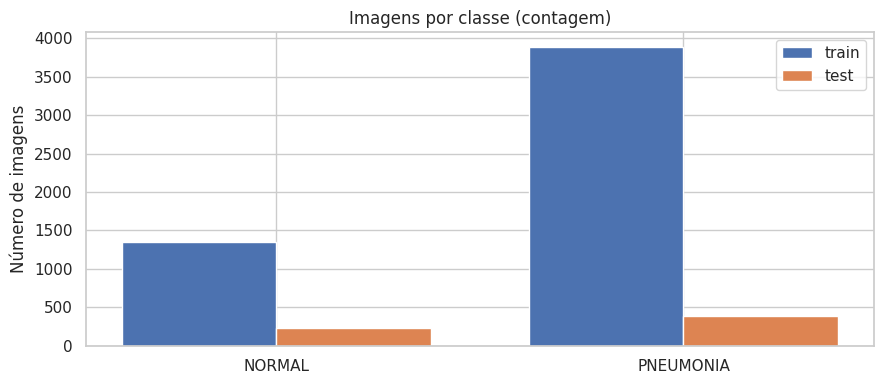

In [ ]:
def plot_class_counts(train_df, test_df, class_col="class"):
    train_counts = train_df[class_col].value_counts()
    test_counts  = test_df[class_col].value_counts()

    classes = sorted(set(train_counts.index).union(set(test_counts.index)))
    train_vals = [int(train_counts.get(c, 0)) for c in classes]
    test_vals  = [int(test_counts.get(c, 0)) for c in classes]

    x = np.arange(len(classes))
    width = 0.38

    plt.figure(figsize=(9, 4))
    plt.bar(x - width/2, train_vals, width=width, label="train")
    plt.bar(x + width/2, test_vals,  width=width, label="test")
    plt.xticks(x, classes)
    plt.ylabel("Número de imagens")
    plt.title("Imagens por classe (contagem)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_class_counts(train_df, test_df)


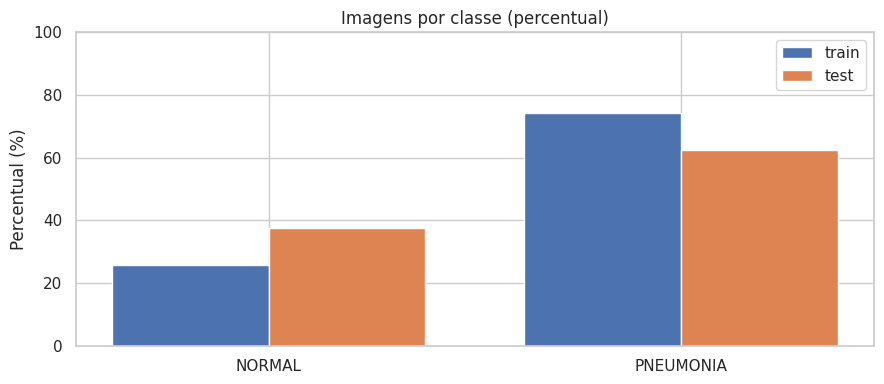

In [ ]:
def plot_class_percent(train_df, test_df, class_col="class"):
    train_perc = train_df[class_col].value_counts(normalize=True) * 100
    test_perc  = test_df[class_col].value_counts(normalize=True) * 100

    classes = sorted(set(train_perc.index).union(set(test_perc.index)))
    train_vals = [float(train_perc.get(c, 0.0)) for c in classes]
    test_vals  = [float(test_perc.get(c, 0.0)) for c in classes]

    x = np.arange(len(classes))
    width = 0.38

    plt.figure(figsize=(9, 4))
    plt.bar(x - width/2, train_vals, width=width, label="train")
    plt.bar(x + width/2, test_vals,  width=width, label="test")
    plt.xticks(x, classes)
    plt.ylabel("Percentual (%)")
    plt.ylim(0, 100)
    plt.title("Imagens por classe (percentual)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_class_percent(train_df, test_df)


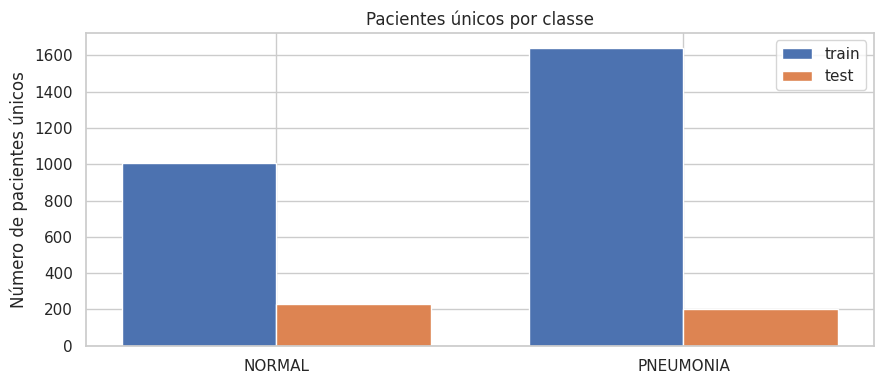

In [ ]:
def plot_unique_patients_per_class(train_df, test_df, class_col="class", patient_col="patient_id"):
    train_pat = train_df.groupby(class_col)[patient_col].nunique()
    test_pat  = test_df.groupby(class_col)[patient_col].nunique()

    classes = sorted(set(train_pat.index).union(set(test_pat.index)))
    train_vals = [int(train_pat.get(c, 0)) for c in classes]
    test_vals  = [int(test_pat.get(c, 0)) for c in classes]

    x = np.arange(len(classes))
    width = 0.38

    plt.figure(figsize=(9, 4))
    plt.bar(x - width/2, train_vals, width=width, label="train")
    plt.bar(x + width/2, test_vals,  width=width, label="test")
    plt.xticks(x, classes)
    plt.ylabel("Número de pacientes únicos")
    plt.title("Pacientes únicos por classe")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_unique_patients_per_class(train_df, test_df)


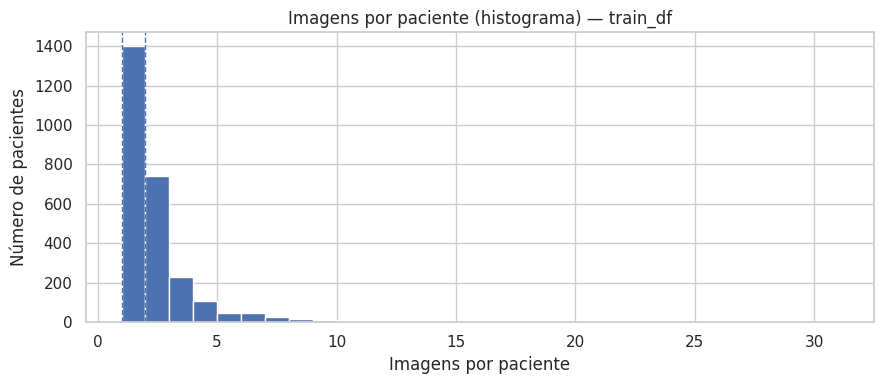

In [ ]:
def plot_images_per_patient_hist(df, name, patient_col="patient_id"):
    counts = df.groupby(patient_col).size().values
    max_v = int(counts.max())
    bins = np.arange(1, max_v + 2) if max_v <= 50 else 50

    mean_v = counts.mean()
    median_v = float(np.median(counts))

    plt.figure(figsize=(9, 4))
    plt.hist(counts, bins=bins)
    plt.axvline(mean_v, linestyle="--", linewidth=1)
    plt.axvline(median_v, linestyle="--", linewidth=1)
    plt.title(f"Imagens por paciente (histograma) — {name}")
    plt.xlabel("Imagens por paciente")
    plt.ylabel("Número de pacientes")
    plt.tight_layout()
    plt.show()

plot_images_per_patient_hist(train_df, "train_df")


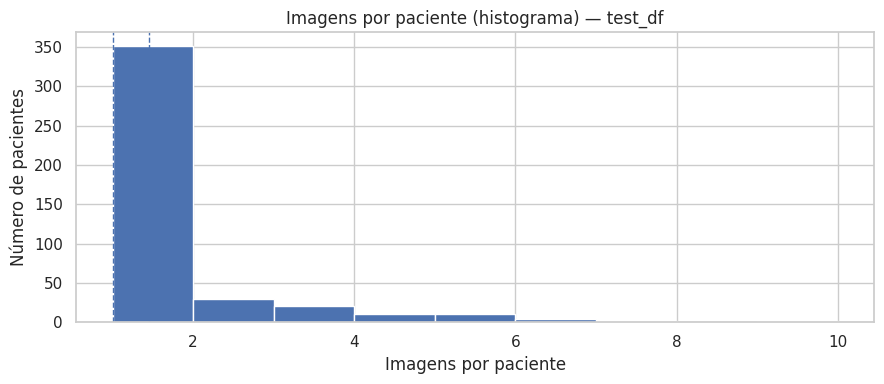

In [ ]:
plot_images_per_patient_hist(test_df, "test_df")


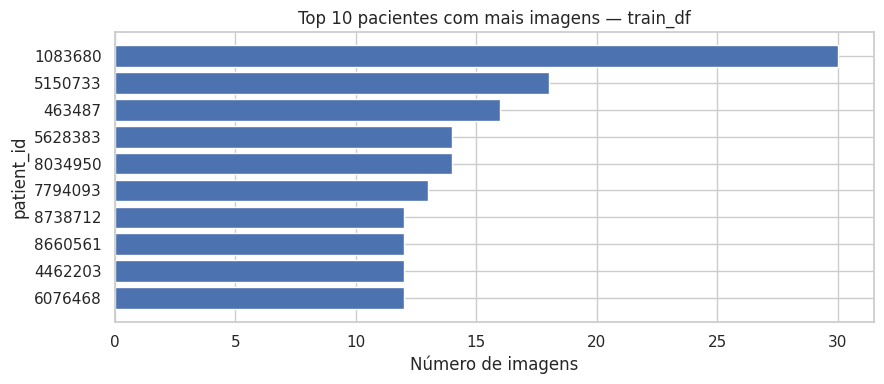

In [ ]:
def plot_top_patients(df, name, patient_col="patient_id", top_k=10):
    top = df.groupby(patient_col).size().sort_values(ascending=False).head(top_k)
    # ordenar para barh ficar legível
    top = top.sort_values(ascending=True)

    plt.figure(figsize=(9, 4))
    plt.barh([str(i) for i in top.index], top.values)
    plt.title(f"Top {top_k} pacientes com mais imagens — {name}")
    plt.xlabel("Número de imagens")
    plt.ylabel("patient_id")
    plt.tight_layout()
    plt.show()

plot_top_patients(train_df, "train_df", top_k=10)


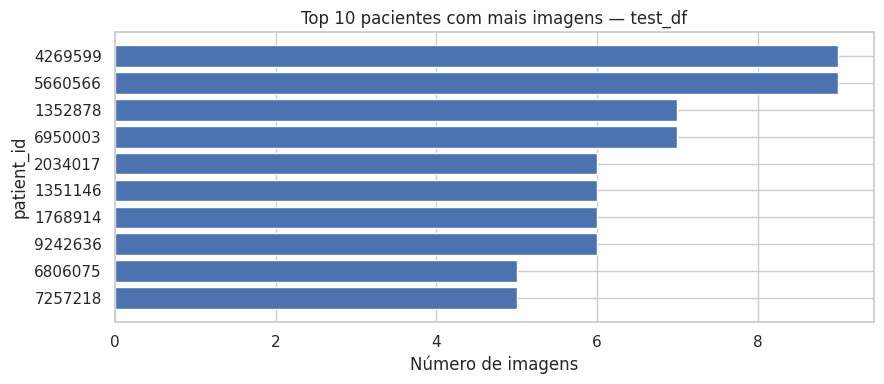

In [ ]:
plot_top_patients(test_df, "test_df", top_k=10)


## Análise de distribuição (train_df e test_df)

Esta seção descreve a distribuição do dataset em três níveis:
- distribuição de imagens por classe (contagem e percentual)
- distribuição de pacientes únicos por classe
- distribuição de imagens por paciente (incluindo casos extremos)

O objetivo é registrar fatores que afetam decisões de pré-processamento e a estratégia de divisão dos dados.

## Distribuição de imagens por classe

No conjunto de treino, a classe PNEUMONIA é majoritária (3883 imagens; 74,22%) em relação à classe NORMAL (1349 imagens; 25,78%). Trata-se de desbalanceamento significativo, o que reduz a utilidade de acurácia como métrica principal e tende a exigir monitoramento de métricas robustas a desbalanceamento.

No conjunto de teste, PNEUMONIA permanece majoritária (390 imagens; 62,5%), mas o desbalanceamento é menor do que no treino (NORMAL: 234 imagens; 37,5%). As proporções de classe diferem entre treino e teste, o que deve ser documentado, pois pode alterar a interpretação de resultados quando métricas forem comparadas entre conjuntos.

## Distribuição de pacientes únicos por classe

No treino, há 1642 pacientes únicos em PNEUMONIA e 1008 em NORMAL (total: 2650). O desbalanceamento existe também no nível de paciente, e não apenas no nível de imagens.

No teste, há 229 pacientes únicos em NORMAL e 202 em PNEUMONIA (total: 431). Isso indica distribuição de pacientes mais equilibrada no teste do que no treino.

## Distribuição de imagens por paciente e casos extremos

No treino, a maior parte dos pacientes possui apenas 1 imagem (mediana = 1), com média aproximada de 1,97 imagens por paciente, e presença de outliers relevantes (máximo = 30 imagens para um paciente). A existência de pacientes com muitas imagens cria dois riscos:
1) vazamento de informação se a divisão futura for feita por imagem (o mesmo paciente pode aparecer em treino e validação/teste);
2) influência desproporcional de poucos pacientes no processo de treinamento.

No teste, a distribuição é mais concentrada: mediana = 1, média aproximada de 1,45 e máximo = 9. A menor quantidade de casos extremos sugere menor concentração de exames em poucos pacientes no conjunto de teste.

## Implicações para pré-processamento e organização do pipeline

- A presença de múltiplas imagens por paciente torna recomendável que a divisão futura (train/val/test) seja feita por paciente (`patient_id`), evitando vazamento por identidade.
- O desbalanceamento em treino sugere planejamento de avaliação com métricas apropriadas e, se necessário, estratégias de treinamento que lidem com a classe minoritária (por exemplo, ponderação de classes).
- Os pacientes com muitos exames justificam a inspeção de outliers e a definição de regras de amostragem (quando aplicável) para evitar concentração excessiva.


# 6. Análise de Resolução das Imagens

Nesta seção foram analisadas as dimensões das imagens do dataset, com foco em:

- Distribuição de **largura** (width)
- Distribuição de **altura** (height)
- Distribuição do **aspect ratio** (width/height)

O objetivo é entender a variabilidade do tamanho das imagens e decidir uma estratégia adequada de resize para o modelo.


## 6.1 Extração de Dimensões (Width e Height)

A seguir, foram extraídas as dimensões de todas as imagens do conjunto de treino, sendo armazenadas em um DataFrame auxiliar (`sizes_df`).


In [ ]:
def get_image_size(path):
    img = Image.open(path)
    width, height = img.size
    img.close()
    return width, height

sizes_df = train_df.copy()

widths = []
heights = []

for path in sizes_df["image_path"]:

    w, h = get_image_size(path)

    widths.append(w)
    heights.append(h)

sizes_df["width"] = widths
sizes_df["height"] = heights

sizes_df.head()

,image_path,class,filename,patient_id,width,height
0,/content/drive/MyDrive/Desafio_Ligia/Data/ches...,NORMAL,NORMAL-3482198-0003.jpeg,3482198,2418,2260
1,/content/drive/MyDrive/Desafio_Ligia/Data/ches...,NORMAL,NORMAL-3514363-0001.jpeg,3514363,1582,1056
2,/content/drive/MyDrive/Desafio_Ligia/Data/ches...,NORMAL,NORMAL-3484856-0001.jpeg,3484856,1608,1348
3,/content/drive/MyDrive/Desafio_Ligia/Data/ches...,NORMAL,NORMAL-3514363-0004.jpeg,3514363,1414,1106
4,/content/drive/MyDrive/Desafio_Ligia/Data/ches...,NORMAL,NORMAL-3514363-0002.jpeg,3514363,1446,1391


## 6.2 Distribuição de Largura (Width)

Como a largura (em pixels) está distribuída no conjunto de treino.
Isso ajuda a entender se as imagens têm tamanhos muito variados e se existem outliers.


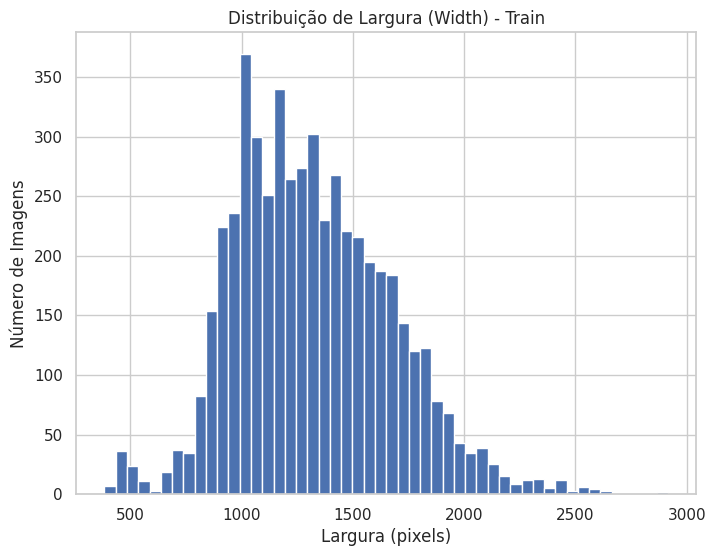

In [ ]:
plt.figure()
plt.hist(sizes_df["width"], bins=50)
plt.title("Distribuição de Largura (Width) - Train")
plt.xlabel("Largura (pixels)")
plt.ylabel("Número de Imagens")
plt.show()

## 6.3 Distribuição de Altura (Height)

Agora fazendo o mesmo para a altura (em pixels). Isso permite comparar se a variação acontece mais na altura, na largura ou em ambos.


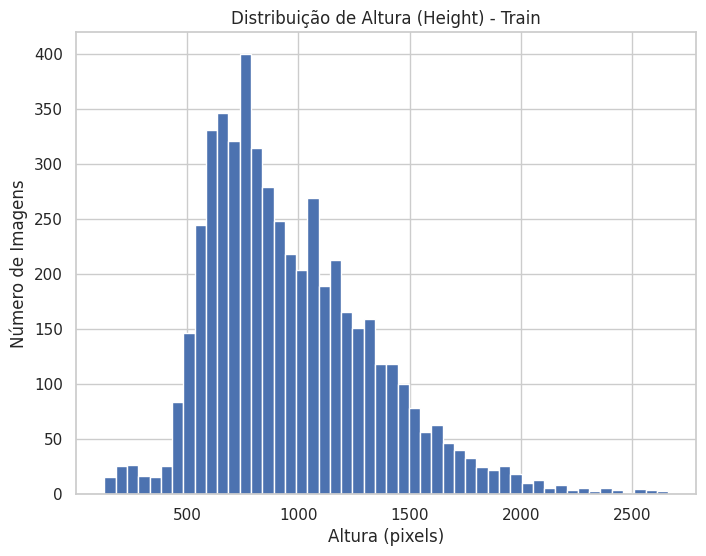

In [ ]:
plt.figure()
plt.hist(sizes_df["height"], bins=50)
plt.title("Distribuição de Altura (Height) - Train")
plt.xlabel("Altura (pixels)")
plt.ylabel("Número de Imagens")
plt.show()


## 6.4 Aspect Ratio (Width / Height)

O aspect ratio é a razão entre largura e altura:

aspect_ratio = width / height

Ele é importante para decidir o resize.

In [ ]:
aspect_ratios = []

for i in range(len(sizes_df)):
    w = sizes_df.loc[i, "width"]
    h = sizes_df.loc[i, "height"]
    aspect_ratios.append(w / h)

sizes_df["aspect_ratio"] = aspect_ratios

sizes_df[["width", "height", "aspect_ratio"]].head()


,width,height,aspect_ratio
0,2418,2260,1.069912
1,1582,1056,1.498106
2,1608,1348,1.192878
3,1414,1106,1.278481
4,1446,1391,1.039540


In [ ]:
sizes_df[["width", "height", "aspect_ratio"]].describe()


,width,height,aspect_ratio
count,5232.000000,5232.000000,5232.000000
mean,1320.695336,968.181384,1.440047
std,355.024600,378.542729,0.257115
min,384.000000,127.000000,0.835391
25%,1056.000000,688.000000,1.257206
50%,1284.000000,888.000000,1.411426
75%,1552.000000,1187.750000,1.583333
max,2916.000000,2663.000000,3.378788


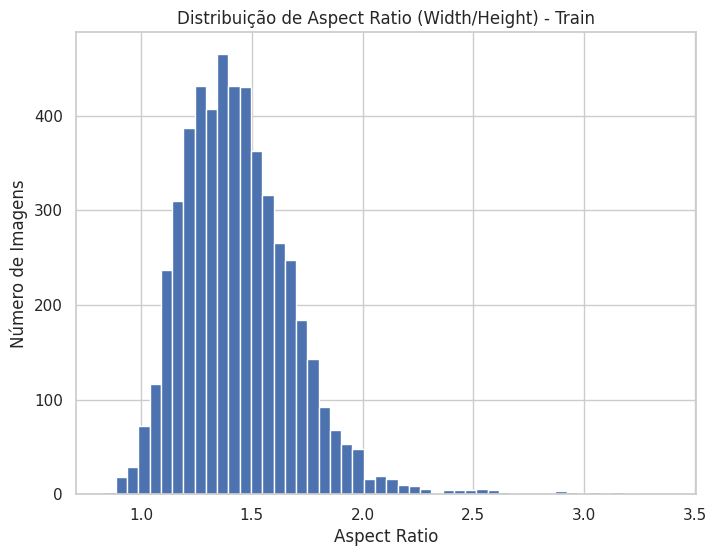

In [ ]:
plt.figure()
plt.hist(sizes_df["aspect_ratio"], bins=50)
plt.title("Distribuição de Aspect Ratio (Width/Height) - Train")
plt.xlabel("Aspect Ratio")
plt.ylabel("Número de Imagens")
plt.show()


## 6.5 Identificação de Outliers

Aqui são identificadas imagens muito pequenas ou muito grandes.
Isso ajuda a perceber se existe algum conjunto de imagens fora do padrão.


In [ ]:
areas = []

for i in range(len(sizes_df)):
    w = sizes_df.loc[i, "width"]
    h = sizes_df.loc[i, "height"]
    areas.append(w * h)

sizes_df["area"] = areas
sizes_df[["width", "height", "area"]].head()


,width,height,area
0,2418,2260,5464680
1,1582,1056,1670592
2,1608,1348,2167584
3,1414,1106,1563884
4,1446,1391,2011386


In [ ]:
sizes_sorted_small = sizes_df.sort_values("area", ascending=True)
sizes_sorted_small[["image_path", "class", "width", "height", "area"]].head(5)


,image_path,class,width,height,area
1409,/content/drive/MyDrive/Desafio_Ligia/Data/ches...,PNEUMONIA,384,127,48768
1393,/content/drive/MyDrive/Desafio_Ligia/Data/ches...,PNEUMONIA,400,138,55200
3312,/content/drive/MyDrive/Desafio_Ligia/Data/ches...,PNEUMONIA,446,132,58872
3291,/content/drive/MyDrive/Desafio_Ligia/Data/ches...,PNEUMONIA,445,140,62300
3513,/content/drive/MyDrive/Desafio_Ligia/Data/ches...,PNEUMONIA,437,144,62928


In [ ]:
sizes_sorted_large = sizes_df.sort_values("area", ascending=False)
sizes_sorted_large[["image_path", "class", "width", "height", "area"]].head(5)


,image_path,class,width,height,area
976,/content/drive/MyDrive/Desafio_Ligia/Data/ches...,NORMAL,2916,2583,7532028
1342,/content/drive/MyDrive/Desafio_Ligia/Data/ches...,NORMAL,2890,2534,7323260
901,/content/drive/MyDrive/Desafio_Ligia/Data/ches...,NORMAL,2694,2625,7071750
1088,/content/drive/MyDrive/Desafio_Ligia/Data/ches...,NORMAL,2619,2628,6882732
641,/content/drive/MyDrive/Desafio_Ligia/Data/ches...,NORMAL,2633,2578,6787874


## Conclusão da Análise de Resolução

A análise das dimensões das imagens revelou que o dataset apresenta variação significativa tanto nas dimensões individuais quanto no tamanho total das imagens.

### Distribuição de Largura (Width)

- A largura varia aproximadamente entre ~400 e ~2900 pixels.
- A maior concentração de imagens está entre ~900 e ~1600 pixels.
- Há presença de imagens muito pequenas e muito grandes, caracterizando outliers.

### Distribuição de Altura (Height)

- A altura varia aproximadamente entre ~130 e ~2600 pixels.
- A maior parte das imagens concentra-se entre ~600 e ~1200 pixels.
- Também há presença de valores extremos.

### Aspect Ratio (Width / Height)

A distribuição do aspect ratio mostra que:

- A maior concentração de imagens está aproximadamente entre ~1.1 e ~1.6.
- Existe uma cauda à direita que se estende até valores próximos de ~2.5 ou superiores.
- Embora a maioria das imagens mantenha proporções semelhantes, há variação perceptível entre os extremos.

Isso indica que:

- O dataset não é composto por imagens perfeitamente padronizadas em proporção.
- A maioria mantém proporções próximas, mas existem casos com proporções mais alongadas.
- Há heterogeneidade suficiente para considerar que diferentes formatos coexistem no conjunto.

Portanto, apesar de não haver casos extremos muito frequentes, a variabilidade do aspect ratio não pode ser considerada totalmente desprezível.


### Área (Width × Height)

Ao analisar a área:

- Observa-se grande variação no volume total de informação visual.
- Existem imagens muito pequenas (com poucas dezenas de milhares de pixels).
- Existem imagens muito grandes (com milhões de pixels).
- A maior parte do dataset concentra-se em uma faixa intermediária de área.

Essa heterogeneidade de área indica que o dataset possui diferentes níveis de resolução e detalhamento, o que pode influenciar:

- quantidade de informação disponível por imagem
- custo computacional no processamento
- sensibilidade do modelo a padrões finos

### Interpretação Geral

O dataset apresenta:

- Alta variabilidade nas dimensões absolutas.
- Aspect ratio concentrado em uma faixa predominante, porém com variação perceptível e presença de cauda à direita.
- Grande variação na quantidade total de pixels (área).

Essas observações são fundamentais para embasar as decisões futuras relacionadas ao pré-processamento das imagens.


# 7. EDA Visual

Nesta seção foi realizada uma análise visual das imagens do dataset.

O objetivo é:

- Observar diferenças visuais entre as classes.
- Identificar padrões como opacidades, contraste e textura.
- Detectar possíveis problemas como imagens muito escuras, muito claras ou com baixa qualidade.



## 7.1 Amostras da Classe NORMAL

Nesta etapa foram selecionadas algumas imagens da classe NORMAL para inspeção visual.

Isso permite observar:

- Estrutura pulmonar típica
- Nível de contraste
- Presença ou ausência de opacidades


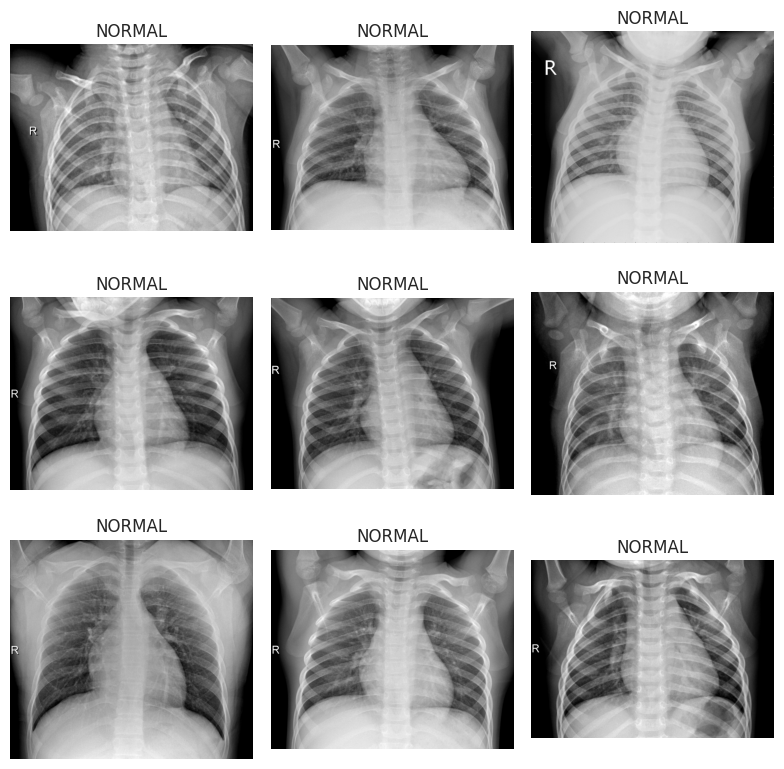

In [ ]:
import random

normal_images = sizes_df[sizes_df["class"] == "NORMAL"]
normal_sample = normal_images.sample(9, random_state=42)

plt.figure(figsize=(8,8))

i = 1

for index, row in normal_sample.iterrows():

    img = Image.open(row["image_path"])

    plt.subplot(3,3,i)
    plt.imshow(img, cmap="gray")
    plt.title("NORMAL")
    plt.axis("off")

    i = i + 1

plt.tight_layout()
plt.show()


## 7.2 Amostras da Classe PNEUMONIA

Agora foram selecionadas imagens da classe PNEUMONIA para comparação visual.

O objetivo é observar possíveis diferenças como:

- Áreas esbranquiçadas (opacidades)
- Regiões com maior densidade
- Redução de contraste em partes do pulmão


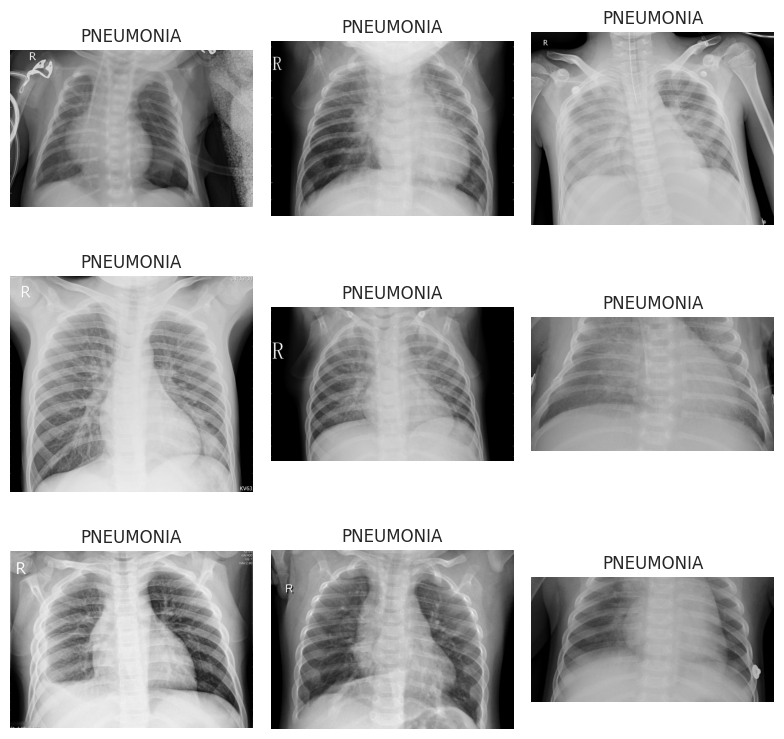

In [ ]:
pneumonia_images = sizes_df[sizes_df["class"] == "PNEUMONIA"]
pneumonia_sample = pneumonia_images.sample(9, random_state=42)

plt.figure(figsize=(8,8))

i = 1

for index, row in pneumonia_sample.iterrows():

    img = Image.open(row["image_path"])

    plt.subplot(3,3,i)
    plt.imshow(img, cmap="gray")
    plt.title("PNEUMONIA")
    plt.axis("off")

    i = i + 1

plt.tight_layout()
plt.show()


## 7.3 Comparação Visual Entre Classes

Nesta etapa foram exibidas as imagens NORMAL e PNEUMONIA lado a lado para facilitar a comparação visual direta.


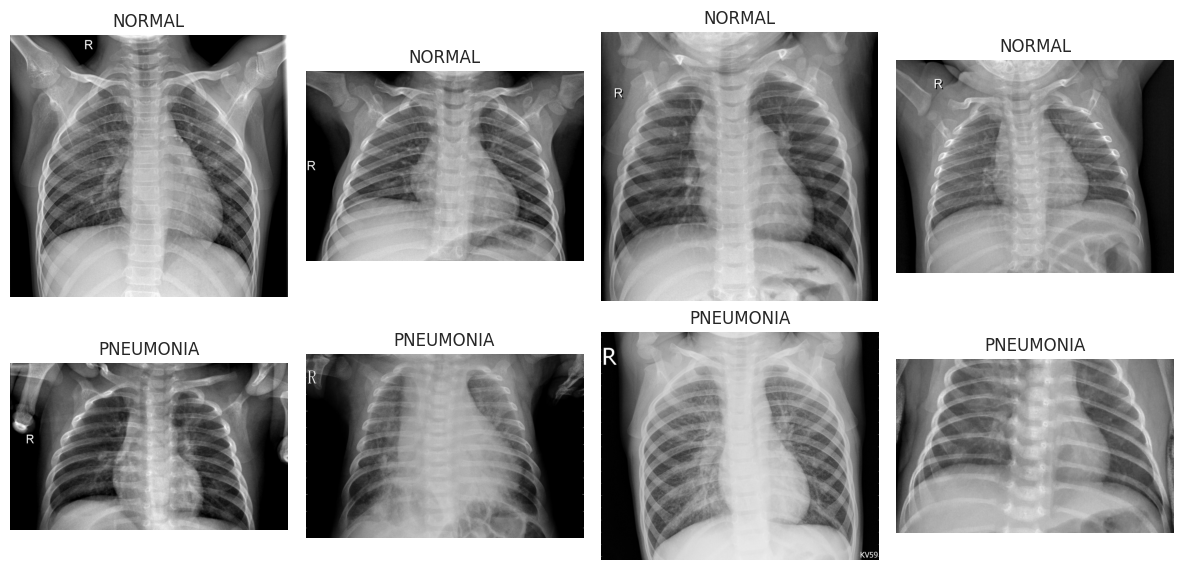

In [ ]:
normal_images = sizes_df[sizes_df["class"] == "NORMAL"]
pneumonia_images = sizes_df[sizes_df["class"] == "PNEUMONIA"]

normal_sample = normal_images.sample(4, random_state=None)
pneumonia_sample = pneumonia_images.sample(4, random_state=None)


plt.figure(figsize=(12,6))

i = 1
for index, row in normal_sample.iterrows():

    img = Image.open(row["image_path"])

    plt.subplot(2,4,i)
    plt.imshow(img, cmap="gray")
    plt.title("NORMAL")
    plt.axis("off")

    i = i + 1

for index, row in pneumonia_sample.iterrows():

    img = Image.open(row["image_path"])

    plt.subplot(2,4,i)
    plt.imshow(img, cmap="gray")
    plt.title("PNEUMONIA")
    plt.axis("off")

    i = i + 1

plt.tight_layout()
plt.show()


## Conclusão da Análise Visual (EDA Visual)

A comparação visual entre amostras das classes NORMAL e PNEUMONIA indica que ambas apresentam heterogeneidade intra-classe, o que é esperado em dados reais de radiografia.

### Principais observações

- **Variabilidade de aquisição**: há diferenças perceptíveis de brilho, contraste, nitidez e posicionamento entre exames em ambas as classes.
- **Sobreposição visual**: algumas imagens NORMAL podem apresentar aparência mais “opaca” ou com baixo contraste, o que pode estar relacionado a exposição, ruído, recorte ou posicionamento — e não necessariamente a um padrão patológico.
- **Padrões em PNEUMONIA**: em diversas amostras, nota-se aumento de densidade (regiões mais esbranquiçadas) e perda de contraste em áreas pulmonares, porém a intensidade e a localização dessas alterações variam consideravelmente.
- **Não trivialidade do problema**: a presença de variações técnicas e a sobreposição parcial de padrões visuais sugerem que a classificação não é perfeitamente separável apenas por inspeção visual rápida.

### Interpretação

A análise visual sugere que existem sinais compatíveis com pneumonia em parte das imagens da classe PNEUMONIA, mas também indica que variações de aquisição (contraste/brilho/posicionamento) podem gerar aparências semelhantes em imagens NORMAL.

Isso reforça a necessidade de um pipeline de pré-processamento robusto e de um modelo capaz de generalizar diante de variações de iluminação e contraste.

# 8. Análise de Intensidade de Pixel

Nesta seção foi analizada quantitativamente a distribuição de intensidade dos pixels nas imagens do dataset.

Objetivos:

- Comparar histogramas médios de intensidade entre as classes.
- Calcular média global de intensidade por classe.
- Calcular desvio padrão global por classe.

Essa análise permite verificar se existem diferenças sistemáticas de brilho/contraste entre NORMAL e PNEUMONIA.


## 8.1 Separação das classes

Primeiro, foram separadas as imagens NORMAL e PNEUMONIA.


In [ ]:
normal_images = sizes_df[sizes_df["class"] == "NORMAL"]
pneumonia_images = sizes_df[sizes_df["class"] == "PNEUMONIA"]

print("Total NORMAL:", len(normal_images))
print("Total PNEUMONIA:", len(pneumonia_images))


Total NORMAL: 1349
Total PNEUMONIA: 3883


## 8.2 Função para calcular histograma médio

Foi criada uma função que:

- Lê cada imagem em escala de cinza.
- Converte para array NumPy.
- Calcula o histograma de intensidades (0 a 255).
- Soma os histogramas.
- Divide pelo número de imagens, obtendo o histograma médio.


In [ ]:
def calcular_histograma_medio(df):

    histograma_total = np.zeros(256)
    total_imagens = 0

    for index, row in df.iterrows():

        img = Image.open(row["image_path"]).convert("L")
        img_array = np.array(img)

        histograma, _ = np.histogram(img_array, bins=256, range=(0,255))

        histograma_total = histograma_total + histograma
        total_imagens = total_imagens + 1

        img.close()

    histograma_medio = histograma_total / total_imagens

    return histograma_medio


## 8.3 Cálculo dos histogramas médios por classe


In [ ]:
hist_normal = calcular_histograma_medio(normal_images)
hist_pneumonia = calcular_histograma_medio(pneumonia_images)


## 8.4 Comparação dos histogramas médios

Agora foram comparadas as distribuições médias de intensidade de pixel
entre NORMAL e PNEUMONIA.


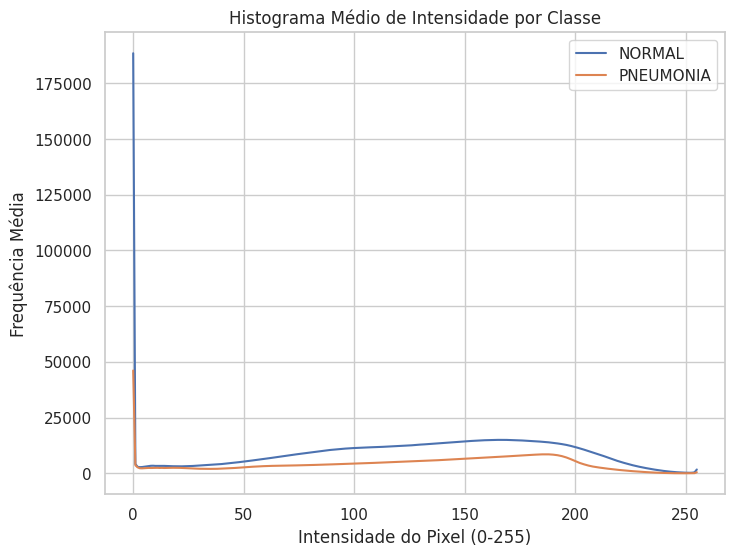

In [ ]:
plt.figure()

plt.plot(hist_normal, label="NORMAL")
plt.plot(hist_pneumonia, label="PNEUMONIA")

plt.title("Histograma Médio de Intensidade por Classe")
plt.xlabel("Intensidade do Pixel (0-255)")
plt.ylabel("Frequência Média")
plt.legend()

plt.show()


## 8.5 Média global de intensidade

Foi calculada a média global de intensidade dos pixels para cada classe.
Isso indica o nível médio de brilho.


In [ ]:
def calcular_media_global(df):

    soma_total = 0
    total_pixels = 0

    for index, row in df.iterrows():

        img = Image.open(row["image_path"]).convert("L")
        img_array = np.array(img)

        soma_total = soma_total + img_array.sum()
        total_pixels = total_pixels + img_array.size

        img.close()

    media_global = soma_total / total_pixels

    return media_global


media_normal = calcular_media_global(normal_images)
media_pneumonia = calcular_media_global(pneumonia_images)

print("Média global NORMAL:", media_normal)
print("Média global PNEUMONIA:", media_pneumonia)


Média global NORMAL: 123.33800490351393
Média global PNEUMONIA: 125.06049265827924


## 8.6 Média e Desvio Padrão Globais

Para evitar uso excessivo de memória, a média e o desvio padrão globais foram calculados de forma incremental (sem armazenar todos os pixels de todas as imagens).

A estratégia é:

- Somar o total de pixels
- Somar o total dos valores dos pixels
- Somar o total dos quadrados dos valores dos pixels

Em seguida:

- média = soma / total_pixels
- variância = (soma_quadrados / total_pixels) - média²
- desvio = sqrt(variância)


In [ ]:
def media_e_desvio_global(df):

    total_pixels = 0
    soma = 0
    soma_quadrados = 0

    for index, row in df.iterrows():

        img = Image.open(row["image_path"]).convert("L")
        arr = np.array(img, dtype=np.float64)
        img.close()

        total_pixels = total_pixels + arr.size
        soma = soma + arr.sum()
        soma_quadrados = soma_quadrados + (arr * arr).sum()

    media = soma / total_pixels
    variancia = (soma_quadrados / total_pixels) - (media * media)

    if variancia < 0:
        variancia = 0

    desvio = np.sqrt(variancia)

    return media, desvio


## 8.7 Resultados: média e desvio padrão globais por classe

Agora calculamos as métricas para NORMAL e PNEUMONIA separadamente.


In [ ]:
normal_images = sizes_df[sizes_df["class"] == "NORMAL"]
pneumonia_images = sizes_df[sizes_df["class"] == "PNEUMONIA"]

media_normal, desvio_normal = media_e_desvio_global(normal_images)
media_pneumonia, desvio_pneumonia = media_e_desvio_global(pneumonia_images)

print("NORMAL - média global:", media_normal)
print("NORMAL - desvio padrão global:", desvio_normal)

print("PNEUMONIA - média global:", media_pneumonia)
print("PNEUMONIA - desvio padrão global:", desvio_pneumonia)


NORMAL - média global: 123.33800490351393
NORMAL - desvio padrão global: 63.81257048803652
PNEUMONIA - média global: 125.06049265827924
PNEUMONIA - desvio padrão global: 61.69719052926863


## Conclusão da Análise de Intensidade de Pixel

A análise quantitativa de intensidade complementa a inspeção visual e reduz a subjetividade percebida anteriormente (a distinção “a olho” entre heterogeneidade de NORMAL e PNEUMONIA ficou incerta devido a variações de brilho/contraste e condições de aquisição).

### Histograma médio por classe

O histograma médio indica um **pico muito forte em intensidades próximas de 0**, sugerindo presença frequente de regiões muito escuras (ex.: bordas, fundo, áreas fora do campo útil da radiografia). Após esse pico inicial, as duas classes apresentam perfis semelhantes, porém com **diferenças sutis na faixa intermediária e alta de intensidades**.

### Média global de intensidade (brilho)

- **NORMAL:** 123.34  
- **PNEUMONIA:** 125.06  

A classe **PNEUMONIA apresenta média global ligeiramente maior**, indicando imagens, em média, um pouco mais claras. Essa diferença é pequena, mas consistente com a intuição de maior “claridade” em regiões pulmonares quando há opacidades.

### Desvio padrão global (contraste)

- **NORMAL:** 63.81  
- **PNEUMONIA:** 61.70  

A classe **NORMAL apresenta desvio padrão ligeiramente maior**, sugerindo **maior variação de intensidades (contraste) no conjunto**. Isso ajuda a explicar por que, na análise visual, algumas imagens NORMAL pareceram “mais heterogêneas” ou até “opacas”: variações de aquisição (exposição/contraste) podem aumentar a dispersão de intensidades mesmo sem padrão patológico.

### Interpretação

As duas classes têm distribuições de intensidade **muito próximas**, com diferenças **sutis**: PNEUMONIA tende a ser ligeiramente mais clara (média maior) e NORMAL tende a ter contraste global ligeiramente maior (desvio padrão maior). Isso indica que **intensidade global, isoladamente, não separa perfeitamente as classes**, mas fornece evidências objetivas para apoiar (ou corrigir) impressões visuais anteriores e reforça a importância de robustez a variações de brilho/contraste nas próximas etapas.


# 9. Análise de Qualidade das Imagens

Esta etapa tem como objetivo identificar possíveis problemas de qualidade no dataset, tais como:

- Imagens excessivamente escuras
- Imagens excessivamente claras
- Imagens com dimensões muito pequenas
- Arquivos corrompidos ou ilegíveis

A identificação desses casos permite avaliar riscos para o treinamento do modelo.


## 9.1 Detecção de Imagens Muito Escuras

Uma imagem é considerada muito escura quando sua média de intensidade é muito baixa.

A métrica utilizada é a média dos valores de pixel (0–255).  
Valores próximos de 0 indicam predominância de tons escuros.


In [ ]:
def detectar_imagens_escuras(df, limite=40):

    imagens_escuras = []

    for index, row in df.iterrows():

        img = Image.open(row["image_path"]).convert("L")
        arr = np.array(img)
        img.close()

        media = arr.mean()

        if media < limite:
            imagens_escuras.append(row["image_path"])

    return imagens_escuras


imagens_escuras = detectar_imagens_escuras(sizes_df, limite=40)

print("Total de imagens muito escuras:", len(imagens_escuras))


Total de imagens muito escuras: 0


## 9.2 Detecção de Imagens Muito Claras

Uma imagem é considerada muito clara quando a média de intensidade é muito alta.

Valores próximos de 255 indicam predominância de tons claros.


In [ ]:
def detectar_imagens_claras(df, limite=210):

    imagens_claras = []

    for index, row in df.iterrows():

        img = Image.open(row["image_path"]).convert("L")
        arr = np.array(img)
        img.close()

        media = arr.mean()

        if media > limite:
            imagens_claras.append(row["image_path"])

    return imagens_claras


imagens_claras = detectar_imagens_claras(sizes_df, limite=210)

print("Total de imagens muito claras:", len(imagens_claras))


Total de imagens muito claras: 1


## 9.3 Verificação de Imagens Muito Pequenas

Imagens com dimensões muito reduzidas podem apresentar baixa quantidade de informação útil.

O critério adotado considera largura ou altura abaixo de um limite mínimo.


In [ ]:
def detectar_imagens_pequenas(df, limite_dimensao=300):

    imagens_pequenas = []

    for index, row in df.iterrows():

        largura = row["width"]
        altura = row["height"]

        if largura < limite_dimensao or altura < limite_dimensao:
            imagens_pequenas.append(row["image_path"])

    return imagens_pequenas


imagens_pequenas = detectar_imagens_pequenas(sizes_df, limite_dimensao=300)

print("Total de imagens pequenas:", len(imagens_pequenas))


Total de imagens pequenas: 76


## 9.4 Verificação de Arquivos Corrompidos

Arquivos corrompidos podem gerar erro ao serem abertos.

A verificação consiste em tentar abrir cada imagem e registrar falhas.


In [ ]:
def verificar_corrupcao(df):

    arquivos_corrompidos = []

    for index, row in df.iterrows():

        try:
            img = Image.open(row["image_path"])
            img.verify()
            img.close()

        except Exception:
            arquivos_corrompidos.append(row["image_path"])

    return arquivos_corrompidos


arquivos_corrompidos = verificar_corrupcao(sizes_df)

print("Total de arquivos corrompidos:", len(arquivos_corrompidos))


Total de arquivos corrompidos: 0


## Conclusão da Análise de Qualidade das Imagens

A análise de qualidade revelou os seguintes resultados:

- **Imagens muito escuras:** 0  
- **Imagens muito claras:** 1  
- **Imagens pequenas:** 76  
- **Arquivos corrompidos:** 0  

### Interpretação

Não foram identificadas imagens excessivamente escuras, o que indica ausência de subexposição severa no conjunto analisado. Apenas uma imagem apresentou média de intensidade elevada o suficiente para ser classificada como muito clara, sugerindo que superexposição não é um problema recorrente no dataset.

Não foram detectados arquivos corrompidos, o que indica integridade estrutural adequada dos dados.

Foram identificadas 76 imagens com dimensões reduzidas em relação ao critério adotado. Essas imagens representam uma fração pequena do total, mas podem conter menor quantidade de informação visual e potencialmente sofrer maior degradação ao serem redimensionadas nas etapas posteriores de pré-processamento.

### Conclusão Geral

O dataset apresenta boa qualidade estrutural, sem problemas relevantes de exposição extrema ou corrupção de arquivos. A principal atenção futura deve estar associada às imagens de menor dimensão, que podem demandar cuidado específico durante o pré-processamento.


# 10. Split Treino/Validação

Mesmo existindo uma pasta `test` no dataset, a validação interna é necessária para:

- acompanhar desempenho durante o treinamento (ex.: ROC-AUC)
- ajustar hiperparâmetros sem “olhar” o conjunto de teste repetidamente
- reduzir risco de overfitting
- manter reprodutibilidade

A divisão será feita como:

- **80% treino**
- **20% validação**
- **split feito por paciente**
- **estratificado por classe** (para manter a proporção de NORMAL e PNEUMONIA)
- **seed fixa** (para reprodutibilidade)

A divisão será realizada no nível de patient_id, garantindo que todas as imagens de um mesmo paciente pertençam exclusivamente a um único subconjunto (treino ou validação).

A estratificação será feita com base na classe do paciente, preservando a proporção de NORMAL e PNEUMONIA entre os conjuntos.

Essa estratégia reduz o risco de vazamento indireto de informação e aumenta a confiabilidade da avaliação do modelo.




## 10.1 Definição da base para o split

A divisão será feita a partir do `train_df`, que contém:

- caminho da imagem (`image_path`)
- rótulo da classe (`class`)

O objetivo é separar o conjunto de treino em dois conjuntos, um para treino de fato e outro para validação, sendo que essa divisão será realizada por paciente, uma vez que há várias imagens por pacientes, então é preciso ter atenção para possíveis vazamentos de dados.


In [ ]:
from sklearn.model_selection import train_test_split

SEED = 42
TEST_SIZE = 0.2

print("Seed definida:", SEED)
print("Proporção para validação:", TEST_SIZE)
print("Total de amostras disponíveis em train_df:", len(train_df))


Seed definida: 42
Proporção para validação: 0.2
Total de amostras disponíveis em train_df: 5232


## 10.2 Realização do split estratificado (80/20)

A função `train_test_split` será utilizada com `stratify`,
garantindo que a distribuição das classes seja preservada nos dois conjuntos.

- `train_df_split` representa o conjunto de treino (80%)
- `val_df` representa o conjunto de validação (20%)


In [ ]:
train_df_split, val_df = train_test_split(
    train_df,
    test_size=TEST_SIZE,
    random_state=SEED,
    stratify=train_df["class"]
)

print("Total treino:", len(train_df_split))
print("Total validação:", len(val_df))


Total treino: 4185
Total validação: 1047


## 10.3 Verificação de vazamento entre treino e validação

Para evitar data leakage, será verificado se existe qualquer imagem
aparecendo ao mesmo tempo em `train_df_split` e `val_df`.

A condição esperada é:

- interseção igual a zero


## 10.4 Observação importante sobre o conjunto `test`

O conjunto `test` do dataset será mantido separado e não será usado durante:

- ajuste de hiperparâmetros
- decisões de pipeline
- comparação de modelos

Ele será utilizado apenas na etapa final de avaliação, para inferência do modelo que aprensentar melhor desempenho na etapa de modelagem.


# 11. Conclusão Final do EDA

A análise exploratória permitiu avaliar integridade, distribuição e características estruturais das imagens antes do pré-processamento.

Do ponto de vista estrutural:

- Não foram encontrados valores ausentes.
- Não há caminhos inválidos nem inconsistências nos metadados principais.
- Não foram identificadas duplicatas por `image_path` ou `filename`.
- Foram detectadas imagens idênticas pixel a pixel dentro dos conjuntos (24 grupos no treino, 3 no teste), totalizando 50 imagens no treino e 6 no teste. Essas duplicatas são internas e não indicam, até o momento, vazamento entre treino e teste, mas podem gerar peso excessivo de determinadas amostras durante o treinamento.

Quanto à distribuição:

- O conjunto de treino apresenta desbalanceamento relevante, com predominância da classe PNEUMONIA.
- O desbalanceamento também ocorre no nível de paciente.
- Há múltiplas imagens por paciente, incluindo casos extremos com alta concentração de exames em poucos indivíduos, o que reforça a necessidade de divisão por `patient_id` para evitar vazamento futuro.

Em relação à resolução das imagens:

- Existe variabilidade considerável em largura, altura e área.
- Há presença de outliers (imagens muito pequenas ou muito grandes).
- A razão de aspecto apresenta variação moderada.
  
Esses fatores indicam que o pré-processamento deverá padronizar dimensões de forma consistente (resize com preservação de proporção e possível padding), evitando distorções geométricas.

Quanto à intensidade e contraste:

- A distribuição de média de intensidade é relativamente semelhante entre as classes.
- O contraste (desvio padrão por imagem) apresenta variação, mas sem separação evidente entre classes.
- Não foram observados problemas sistemáticos de imagens excessivamente escuras ou superexpostas.

De forma geral, o dataset apresenta boa integridade e qualidade visual. Os principais pontos de atenção para as próximas etapas são: tratamento das duplicatas internas, controle do desbalanceamento de classes, divisão por paciente e padronização cuidadosa das dimensões das imagens.
